In [151]:
import json

import agama
import h5py
import halo_analysis as halo
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.io import ascii
from gc_utils import iteration_name, main_prog_halt, snapshot_name  # type: ignore

In [2]:
simulation = "m12i"

sim_dir = "/Users/z5114326/Documents/simulations/"
data_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/"

fire_dir = sim_dir + simulation + "/" + simulation + "_res7100/"

sim = simulation

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "a")  # open processed data file

In [7]:
proc_data["it000"]["source"].keys()

<KeysViewHDF5 ['accretion_flag', 'analyse_flag', 'feh', 'form_lbt', 'form_time', 'gc_id', 'group_id', 'halo_acc_cid', 'halo_acc_tid', 'halo_pre_acc_cid', 'halo_pre_acc_tid', 'halo_z0', 'halo_zform', 'is_mpb', 'last_snap', 'logm_tform', 'logm_z0', 'ptype', 'pubsnap_zform', 'quality', 'real_flag', 'snap_acc', 'snap_pre_acc', 'snap_zform', 'survive_flag', 'survived_accretion', 't_acc', 't_dis', 'zform']>

In [28]:
source_dat = proc_data["it000"]["source"]

mask = (np.array(source_dat["group_id"]) == 0) & (np.array(source_dat["analyse_flag"]) == 1)
gc_id = np.array(proc_data["it000"]["source"]["gc_id"][mask])
t_form = np.array(proc_data["it000"]["source"]["form_time"][mask])
t_disr = np.array(proc_data["it000"]["source"]["t_dis"][mask])

In [ ]:
t_from_surv = []
t_from_disr = []

for t_f, t_d in zip(t_form, t_disr):
    if t_d == -1:
        t_from_surv.append(t_f)

    else:
        t_from_disr.append(t_f)

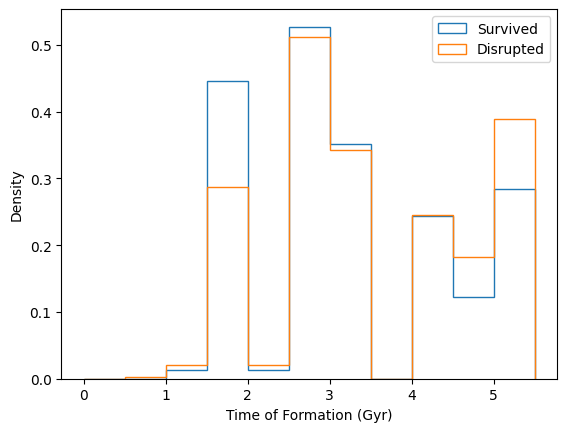

In [ ]:
bins = np.linspace(0, 5.5, 12)
plt.hist(t_from_surv, density=True, bins=bins, histtype="step", label="Survived")
plt.hist(t_from_disr, density=True, bins=bins, histtype="step", label="Disrupted")

plt.xlabel("Time of Formation (Gyr)")
plt.ylabel("Density")

plt.legend()

Text(0, 0.5, 'Count')

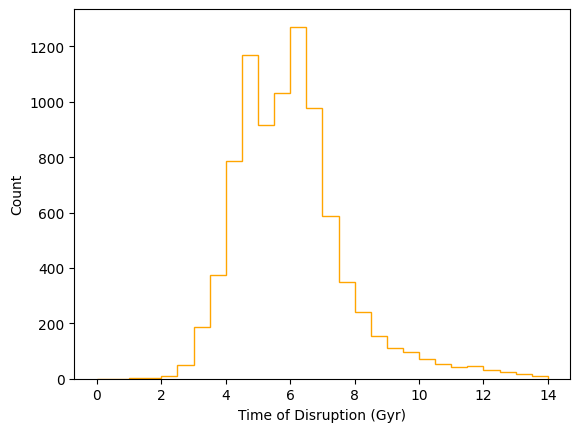

In [57]:
bins = np.linspace(0, 14, 29)
plt.hist(t_disr, bins=bins, histtype="step", color="orange")
plt.xlabel("Time of Disruption (Gyr)")
plt.ylabel("Count")

In [58]:
all_snapshot_fil = "/Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt"
with open(all_snapshot_fil) as f:
    content = f.readlines()
    content = content[5:]
snap_all = ascii.read(content)["i"]
tim_all = ascii.read(content)["time[Gyr]"]

In [62]:
potential_snaps = data_dir + "external/potentials.json"
with open(potential_snaps) as json_file:
    pot_data = json.load(json_file)

pot_snap_lst = pot_data[sim]
pot_time_lst = []
for pot_snap in pot_snap_lst:
    idx = np.where(snap_all == pot_snap)[0][0]
    pot_time_lst.append(tim_all[idx])

In [239]:
t_form_ref_b = []
pot_ref_a = []

t_dif_prop_a = []
for t_f in t_form:
    # time_ref = min(pot_time_lst, key=lambda x: abs(x - t_f))
    filtered = [val for val in pot_time_lst if val >= t_f]
    time_ref_b = min(filtered, default=None)

    t_form_ref_b.append(time_ref_b)

    pot_idx = np.where(pot_time_lst == time_ref_b)[0][0]
    pot_ref_a.append(pot_snap_lst[pot_idx])

    t_dif_prop_a.append(t_f - time_ref_b)

In [ ]:
r_form_lst = []

snap_b = pot_ref_a[156]
pot_file = data_dir + "potentials/" + sim + "/snap_%d/combined_snap_%d.ini" % (snap_b, snap_b)

agama.setUnits(mass=1, length=1, velocity=1)
pot_nbody = agama.Potential(pot_file)
af = agama.ActionFinder(pot_nbody, interp=False)

In [251]:
gc = gc_id[156]
gc

63045197

In [ ]:
snap_id = snapshot_name(snap_b)
snap_id

'snap088'

In [253]:
snap_dict = proc_data["it000"]["snapshots"][snap_id]
snap_dict.keys()

<KeysViewHDF5 ['acc_snap', 'ecc', 'ek', 'ep_agama', 'ep_fire', 'et', 'gc_id', 'group_id', 'jphi', 'jr', 'jz', 'lx', 'ly', 'lz', 'mass', 'phi_cyl', 'ptype', 'r', 'r_apoo', 'r_cyl', 'r_peri', 'vphi_cyl', 'vr_cyl', 'vx', 'vy', 'vz', 'x', 'y', 'z']>

In [254]:
len(pot_ref_a), len(gc_id)

(8764, 8764)

In [255]:
agama.getUnits()["time"]

<Quantity 977.79222168 Myr>

In [256]:
gc_snap_idx = np.where(snap_dict["gc_id"] == gc)[0][0]

pos = [snap_dict["x"][gc_snap_idx], snap_dict["y"][gc_snap_idx], snap_dict["z"][gc_snap_idx]]
vel = [snap_dict["vx"][gc_snap_idx], snap_dict["vy"][gc_snap_idx], snap_dict["vz"][gc_snap_idx]]
ic = pos + vel

In [257]:
t_prop_gyr = (
    t_dif_prop_a[0] * u.Gyr
)  # this is in Gyr, need to cover to time units of AGAMA: 1 time unit = 977.79222Myr
agama_t_unit = agama.getUnits()["time"]
t_prop_agama = t_prop_gyr.to(agama_t_unit)
t_prop_agama = t_prop_agama.value

In [258]:
_, pc = agama.orbit(ic=ic, potential=pot_nbody, time=t_prop_agama, trajsize=1)

radii_pos = pot_nbody.Rperiapo(pc)[0]
r_per = radii_pos[0]
r_apo = radii_pos[1]

eccentricity = (r_apo - r_per) / (r_apo + r_per)

radius = np.linalg.norm(pc[0][:3])

In [294]:
def get_birth_details(sim: str, it: int, sim_dir: str, data_dir: str, birth_dict={}):
    proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
    proc_data = h5py.File(proc_file, "r")  # open processed data file

    it_id = iteration_name(it)
    source_dat = proc_data[it_id]["source"]

    mask = (np.array(source_dat["group_id"]) == 0) & (np.array(source_dat["analyse_flag"]) == 1)
    gc_id = np.array(source_dat["gc_id"][mask])
    t_form = np.array(source_dat["form_time"][mask])
    t_disr = np.array(proc_data["it000"]["source"]["t_dis"][mask])

    all_snapshot_fil = sim_dir + sim + "/" + sim + "_res7100/snapshot_times.txt"
    with open(all_snapshot_fil) as f:
        content = f.readlines()
        content = content[5:]
    snap_all = ascii.read(content)["i"]
    tim_all = ascii.read(content)["time[Gyr]"]

    potential_snaps = data_dir + "external/potentials.json"
    with open(potential_snaps) as json_file:
        pot_data = json.load(json_file)

    pot_snap_lst = pot_data[sim]
    pot_time_lst = []
    for pot_snap in pot_snap_lst:
        idx = np.where(snap_all == pot_snap)[0][0]
        pot_time_lst.append(tim_all[idx])

    t_form_ref_a = []
    t_form_ref_b = []

    pot_ref_a = []
    pot_ref_b = []

    t_dif_prop_a = []
    t_dif_prop_b = []

    for t_f in t_form:
        filtered = [val for val in pot_time_lst if val >= t_f]
        time_ref_a = min(filtered, default=None)
        t_form_ref_a.append(time_ref_a)

        time_ref_b = min(pot_time_lst, key=lambda x: abs(x - t_f))
        t_form_ref_b.append(time_ref_b)

        pot_idx_a = np.where(pot_time_lst == time_ref_a)[0][0]
        pot_ref_a.append(pot_snap_lst[pot_idx_a])

        pot_idx_b = np.where(pot_time_lst == time_ref_b)[0][0]
        pot_ref_b.append(pot_snap_lst[pot_idx_b])

        t_dif_prop_a.append(t_f - time_ref_a)
        t_dif_prop_b.append(t_f - time_ref_b)

    birth_dict["gc_id"] = []
    birth_dict["radius"] = []
    birth_dict["log_mass"] = []
    birth_dict["r_apo"] = []
    birth_dict["r_per"] = []
    birth_dict["ecc"] = []
    birth_dict["t_disrupt"] = []

    failed_count = 0
    total_count = len(gc_id)
    for gc, snap_a, snap_b, t_dif_a, t_dif_b, t_d in zip(
        gc_id, pot_ref_a, pot_ref_b, t_dif_prop_a, t_dif_prop_b, t_disr
    ):
        # for gc, snap_b, t_dif_a in zip(gc_id, pot_ref_b, t_dif_prop_b)

        try:
            snap_id = snapshot_name(snap_a)
            snap_dict = proc_data[it_id]["snapshots"][snap_id]
            gc_snap_idx = np.where(snap_dict["gc_id"] == gc)[0][0]
            pot_file = data_dir + "potentials/" + sim + "/snap_%d/combined_snap_%d.ini" % (snap_a, snap_a)
            t_dif = t_dif_a

        except:
            try:
                snap_id = snapshot_name(snap_b)
                snap_dict = proc_data[it_id]["snapshots"][snap_id]
                gc_snap_idx = np.where(snap_dict["gc_id"] == gc)[0][0]
                pot_file = data_dir + "potentials/" + sim + "/snap_%d/combined_snap_%d.ini" % (snap_b, snap_b)
                t_dif = t_dif_b

            except:
                failed_count += 1
                continue

        pos = [snap_dict["x"][gc_snap_idx], snap_dict["y"][gc_snap_idx], snap_dict["z"][gc_snap_idx]]
        vel = [snap_dict["vx"][gc_snap_idx], snap_dict["vy"][gc_snap_idx], snap_dict["vz"][gc_snap_idx]]
        ic = pos + vel

        agama.setUnits(mass=1, length=1, velocity=1)
        pot_nbody = agama.Potential(pot_file)

        # time is in Gyr, need to convert to time units of AGAMA: 1 time unit = 977.79222Myr
        t_prop_gyr = t_dif * u.Gyr
        agama_t_unit = agama.getUnits()["time"]
        t_prop_agama = t_prop_gyr.to(agama_t_unit)
        t_prop_agama = t_prop_agama.value

        if t_prop_agama == 0:
            pc = ic
            radii_pos = pot_nbody.Rperiapo(pc)
            radius = np.linalg.norm(pc[:3])
        else:
            _, pc = agama.orbit(ic=ic, potential=pot_nbody, time=t_prop_agama, trajsize=1)
            radii_pos = pot_nbody.Rperiapo(pc)[0]
            radius = np.linalg.norm(pc[0][:3])

        # print(radii_pos)
        r_per = radii_pos[0]
        r_apo = radii_pos[1]

        eccentricity = (r_apo - r_per) / (r_apo + r_per)

        gc_source_idx = np.where(gc_id == gc)[0][0]
        log_mass = source_dat["logm_tform"][gc_source_idx]

        birth_dict["gc_id"].append(gc)
        birth_dict["radius"].append(radius)
        birth_dict["log_mass"].append(log_mass)
        birth_dict["r_apo"].append(r_apo)
        birth_dict["r_per"].append(r_per)
        birth_dict["ecc"].append(eccentricity)
        birth_dict["t_disrupt"].append(t_d)

    print("success:", total_count - failed_count, "/", total_count)
    return birth_dict

In [295]:
birth_dict = get_birth_details(sim, 0, sim_dir, data_dir, birth_dict={})

success: 8370 / 8764


In [301]:
dis_mask = np.array(birth_dict["t_disrupt"]) != -1

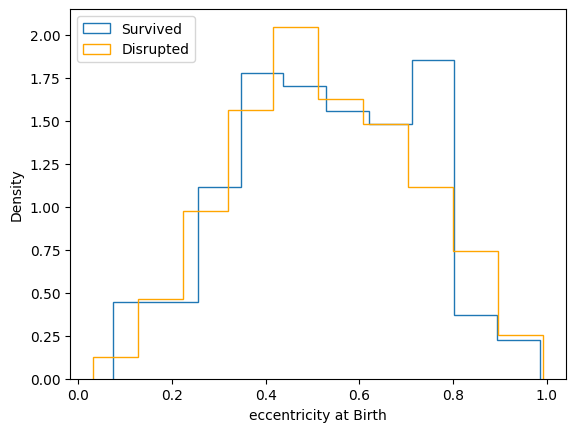

In [323]:
plt.hist(np.array(birth_dict["ecc"])[~dis_mask], histtype="step", density=True, label="Survived")
plt.hist(
    np.array(birth_dict["ecc"])[dis_mask], histtype="step", color="orange", density=True, label="Disrupted"
)

plt.xlabel("eccentricity at Birth")
plt.ylabel("Density")
plt.legend()